## Installation des bibliotèques

In [1]:
!pip install jupyter_contrib_nbextensions
!pip install plantuml
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn


## Importation

In [2]:
from IPython.display import Image
from plantuml import PlantUML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3 as sq

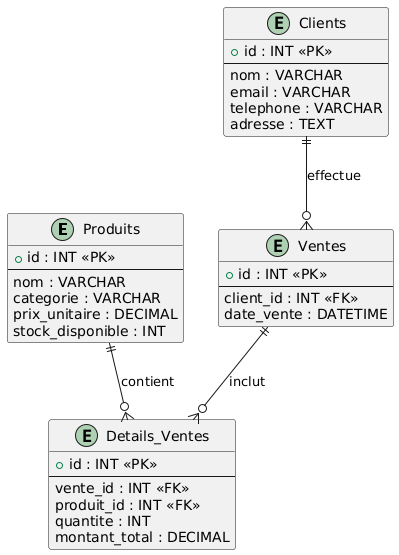

In [3]:


plantuml = PlantUML(url="http://www.plantuml.com/plantuml/img/")
uml_code = """
@startuml
entity Produits {
  + id : INT <<PK>>
  --
  nom : VARCHAR
  categorie : VARCHAR
  prix_unitaire : DECIMAL
  stock_disponible : INT
}

entity Clients {
  + id : INT <<PK>>
  --
  nom : VARCHAR
  email : VARCHAR
  telephone : VARCHAR
  adresse : TEXT
}

entity Ventes {
  + id : INT <<PK>>
  --
  client_id : INT <<FK>>
  date_vente : DATETIME
}

entity Details_Ventes {
  + id : INT <<PK>>
  --
  vente_id : INT <<FK>>
  produit_id : INT <<FK>>
  quantite : INT
  montant_total : DECIMAL
}

Produits ||--o{ Details_Ventes : contient
Clients ||--o{ Ventes : effectue
Ventes ||--o{ Details_Ventes : inclut
@enduml
"""

Image(plantuml.processes(uml_code))


## Extraction de données

In [4]:
connect_db=sq.connect('magasin.db')
pd.read_sql_query('select quantite , montant_total from Details_ventes',connect_db).describe()

,quantite,montant_total
count,59961.000000,59961.000000
mean,5.508681,1394.040878
std,2.871090,1150.636538
min,1.000000,5.060000
25%,3.000000,438.820000
50%,6.000000,1066.020000
75%,8.000000,2090.800000
max,10.000000,4999.100000


In [5]:
mois_dict = {
    1: "Janvier",
    2: "Février",
    3: "Mars",
    4: "Avril",
    5: "Mai",
    6: "Juin",
    7: "Juillet",
    8: "Août",
    9: "Septembre",
    10: "Octobre",
    11: "Novembre",
    12: "Décembre"
}


In [6]:
# Correction de la requête SQL
details_ventes_df = pd.read_sql_query('''
    SELECT

        Produits.nom,
        Produits.prix_unitaire,
        Produits.categorie,
        Details_ventes.quantite,
        Vente.client_id,
        Details_ventes.vente_id,
        Details_ventes.montant_total,
        mois_vente
    FROM
        Details_ventes
    INNER JOIN
        Produits ON Produits.id = Details_ventes.produit_id
    INNER JOIN
        Ventes AS Vente ON Vente.id = Details_ventes.vente_id
    INNER JOIN
        Clients ON Clients.id = Vente.client_id
''', connect_db)

details_ventes_df['mois_vente'] = details_ventes_df['mois_vente'].map(mois_dict)

details_ventes_df

,nom,prix_unitaire,categorie,quantite,client_id,vente_id,montant_total,mois_vente
0,Riz Uncle Ben's,6.07,Alimentation,3,4040,1,18.21,Janvier
1,MacBook Pro,118.44,Électronique,3,5683,2,355.32,Octobre
2,Kinder Bueno,257.07,Alimentation,6,5612,3,1542.42,Janvier
3,Drone DJI,98.20,Électronique,6,7775,4,589.20,Juillet
4,AirPods Pro,50.45,Électronique,8,7775,4,403.60,Juillet
...,...,...,...,...,...,...,...,...
59956,Matelas Emma,394.22,Maison,6,3108,29998,2365.32,Janvier
59957,Mascara Maybelline,73.60,Beauté,5,3108,29998,368.00,Janvier
59958,Lampe Philips Hue,323.82,Maison,8,9843,29999,2590.56,Janvier
59959,Casque Bose,140.24,Électronique,6,9843,29999,841.44,Janvier


In [7]:
details_ventes_df.sort_values(by='quantite',ascending=False)
big_quantity=details_ventes_df.query('quantite>=5').head(10)
big_quantity

,nom,prix_unitaire,categorie,quantite,client_id,vente_id,montant_total,mois_vente
2,Kinder Bueno,257.07,Alimentation,6,5612,3,1542.42,Janvier
3,Drone DJI,98.20,Électronique,6,7775,4,589.20,Juillet
4,AirPods Pro,50.45,Électronique,8,7775,4,403.60,Juillet
6,Café Lavazza,84.20,Alimentation,10,6678,5,842.00,Février
7,Machine à café Nespresso,478.37,Maison,5,6678,5,2391.85,Février
9,Mascara Maybelline,75.34,Beauté,7,9672,7,527.38,Octobre
10,PlayStation 5,133.60,Électronique,8,9672,7,1068.80,Octobre
11,Shampoing Kérastase,41.08,Beauté,7,2687,8,287.56,Juillet
12,Matelas Emma,120.32,Maison,9,2687,8,1082.88,Juillet
13,Chocolat Lindt,124.73,Alimentation,7,8386,9,873.11,Septembre


In [8]:
produits_vendus = details_ventes_df.groupby('nom').agg(
    quantite_totale_vendue=('quantite', 'sum'),
    chiffre_affaire_total=('montant_total', 'sum')
).reset_index()

most_benefits = produits_vendus.sort_values(by='quantite_totale_vendue', ascending=False).head(5)

most_benefits


,nom,quantite_totale_vendue,chiffre_affaire_total
28,Parfum Chanel,10082,2524876.39
35,Shampoing Kérastase,9950,2600539.38
10,Crème Nivea,9836,2453539.85
23,Mascara Maybelline,9313,2450742.77
16,Gel douche Dove,9299,2313528.41


In [9]:
produits_vendus_par_mois = details_ventes_df.groupby('mois_vente')['quantite'].sum().reset_index()
produits_vendus_par_mois

,mois_vente,quantite
0,Août,28094
1,Avril,26816
2,Décembre,28225
3,Février,25902
4,Janvier,28227
5,Juillet,28023
6,Juin,26752
7,Mai,28341
8,Mars,27853
9,Novembre,26897


In [10]:
chiffre_affaire_total=details_ventes_df.montant_total.sum()
float(chiffre_affaire_total)
chiffre_affaire_par_mois=details_ventes_df.groupby('mois_vente')['montant_total'].sum()
chiffre_affaire_par_mois

mois_vente
Août         7113346.14
Avril        6740865.09
Décembre     7180462.33
Février      6459296.46
Janvier      7163429.27
Juillet      7015742.16
Juin         6766095.94
Mai          7146973.64
Mars         7029432.95
Novembre     6922651.52
Octobre      7086704.06
Septembre    6963085.55
Name: montant_total, dtype: float64

In [11]:
max(chiffre_affaire_par_mois)

7180462.33

In [37]:
chiffre_affaire_moyen_par_mois = chiffre_affaire_par_mois.mean()
chiffre_affaire_moyen_par_mois

np.float64(6965673.759166666)

In [13]:
transactions_par_client = details_ventes_df.groupby('client_id')['vente_id'].nunique()
transactions_par_client

client_id
1        2
2        3
3        3
4        5
5        5
        ..
9995     2
9997     3
9998     2
9999     3
10000    2
Name: vente_id, Length: 9498, dtype: int64

In [14]:
transactions_moyen_par_client=transactions_par_client.sum()/transactions_par_client.count()
transactions_moyen_par_client

np.float64(3.158559696778269)

In [15]:
clients_par_chiffre_affaires = details_ventes_df.groupby('client_id')['montant_total'].sum()

top_clients = clients_par_chiffre_affaires.sort_values(ascending=False).head(10)

top_clients

client_id
202     42891.23
7377    38493.55
7015    37193.57
2240    36780.22
5540    35868.47
8836    35424.26
6657    35225.23
542     34424.57
7259    34411.04
1440    34059.30
Name: montant_total, dtype: float64

In [16]:
produits_par_chiffre_affaires = details_ventes_df.groupby('nom')['montant_total'].sum()

produits_par_chiffre_affaires = produits_par_chiffre_affaires.sort_values(ascending=False)

produits_par_chiffre_affaires.head(10)


nom
Shampoing Kérastase      2600539.38
Parfum Chanel            2524876.39
Crème Nivea              2453539.85
Mascara Maybelline       2450742.77
Fond de teint L’Oréal    2384225.99
Gel douche Dove          2313528.41
Rouge à lèvres MAC       2296533.24
Four Samsung             2235845.92
Table Ikea               2216206.34
Nutella                  2198790.57
Name: montant_total, dtype: float64

In [17]:
clients_par_chiffre_affaires = details_ventes_df.groupby('client_id')['montant_total'].sum()

top_10_clients = clients_par_chiffre_affaires.sort_values(ascending=False).head(10)

print("Top 10 clients qui rapportent le plus :")
print(top_10_clients)


Top 10 clients qui rapportent le plus :
client_id
202     42891.23
7377    38493.55
7015    37193.57
2240    36780.22
5540    35868.47
8836    35424.26
6657    35225.23
542     34424.57
7259    34411.04
1440    34059.30
Name: montant_total, dtype: float64


In [18]:
top_10_client_ids = top_10_clients.index.tolist()

query = f"SELECT nom FROM Clients WHERE id IN ({','.join(map(str, top_10_client_ids))})"
top_10_client_names = pd.read_sql_query(query, connect_db)

print("Top 10 clients qui rapportent le plus :")
print(top_10_client_names.to_string(index=False))

Top 10 clients qui rapportent le plus :
           nom
      Lisa Ray
  Tommy Miller
Daniel Bradley
  Angela Lopez
  Crystal Rowe
Bailey Spencer
  George Jones
Shannon Tucker
Nicholas Moran
  Mark Marquez


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Kinder Bueno'),
  Text(1, 0, 'Drone DJI'),
  Text(2, 0, 'AirPods Pro'),
  Text(3, 0, 'Café Lavazza'),
  Text(4, 0, 'Machine à café Nespresso'),
  Text(5, 0, 'Mascara Maybelline'),
  Text(6, 0, 'PlayStation 5'),
  Text(7, 0, 'Shampoing Kérastase'),
  Text(8, 0, 'Matelas Emma'),
  Text(9, 0, 'Chocolat Lindt')])

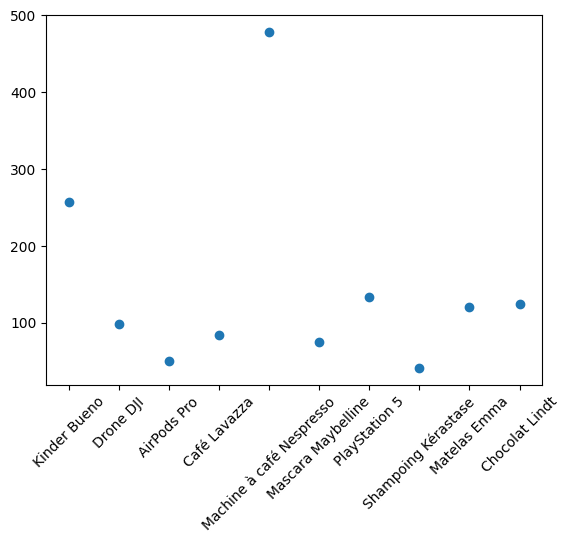

In [19]:
x,y=big_quantity.nom,big_quantity.prix_unitaire

plt.scatter(x,y)
plt.xticks(rotation=45)


## Hypothèses à tester :

   - Pouvoir d'achat limité : Les clients pourraient ne pas avoir suffisamment de moyens financiers pour acheter les produits proposés.

   - Gamme de produits restreinte : La boutique pourrait ne vendre que des produits à consommation quotidienne (ex : produits de première nécessité), limitant ainsi le panier moyen.

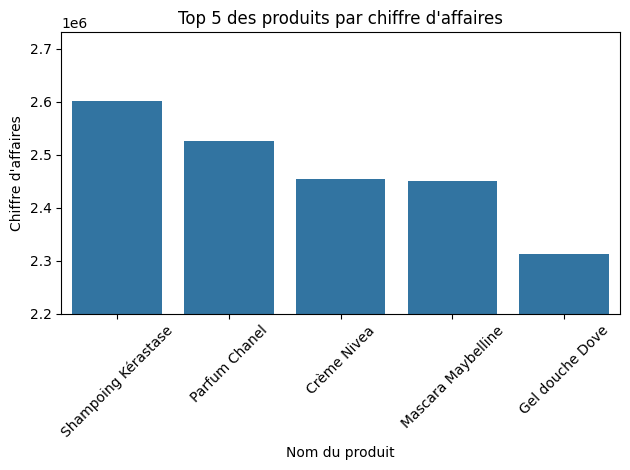

In [20]:
top5 = most_benefits.sort_values(by="chiffre_affaire_total", ascending=False).head(5)

sns.barplot(x="nom", y="chiffre_affaire_total", data=top5)
plt.title("Top 5 des produits par chiffre d'affaires")
plt.xlabel("Nom du produit")
plt.ylabel("Chiffre d'affaires")
plt.xticks(rotation=45)
plt.ylim(2200000,None)
plt.tight_layout()
plt.show()

## Analyse des Produits les Plus Vendus

### Produit phare : Shampoing Kérastase
**Observation** :  
Le Shampoing Kérastase se positionne comme le 2ème produit le plus vendu (9,950 unités) et génère le chiffre d'affaires le plus élevé (2,600,539€).

**Facteurs explicatifs potentiels** :
1. **Usage quotidien/fréquent** :
   - Produit de soin capillaire essentiel avec une fréquence d'utilisation élevée
   - Besoin régulier de réapprovisionnement

2. **Positionnement marché** :
   - Marque reconnue dans le segment premium des soins capillaires
   - Rapport qualité/prix perçu comme favorable (41.08€ l'unité)

3. **Comportement d'achat** :
   - Produit souvent acheté en multiples (quantité moyenne de 7 unités par transaction)
   - Probablement inclus dans des packs promotionnels

### Caractéristiques des Top Produits

- Usage quotidien         
- Soin de base            
- Cosmétique essentiel    
- Hygiène quotidienne     



(6000000.0, 8000000.0)

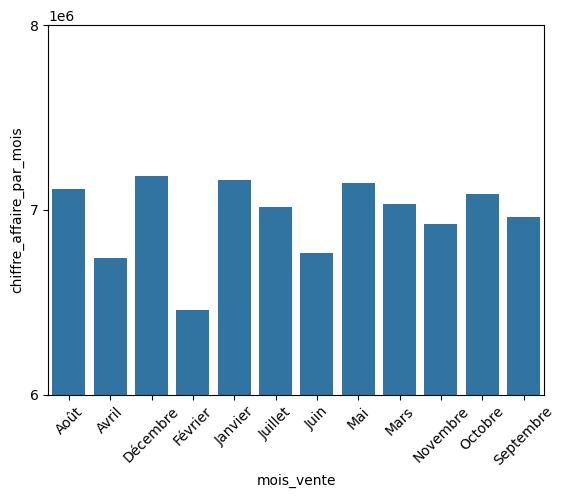

In [21]:
chiffre_affaire_par_mois
chiffre_affaire_par_mois_df = chiffre_affaire_par_mois.reset_index()
chiffre_affaire_par_mois_df.columns = ["mois_vente", "chiffre_affaire_par_mois"]

sns.barplot(chiffre_affaire_par_mois_df,x='mois_vente',y='chiffre_affaire_par_mois')
plt.xticks(rotation=45)
plt.yticks(range(6000000, int(chiffre_affaire_par_mois_df["chiffre_affaire_par_mois"].max()) + 1000000, 1000000))
plt.ylim(6000000, None)

## Hypothèses sur les Variations Saisonnières

### Baisse des ventes en février
**Observation** :  
Nous constatons une baisse significative des ventes en février (25,902 unités vendues pour 6,459,296€), soit environ -8% par rapport à la moyenne mensuelle.

**Hypothèses explicatives** :
- **Fin des soldes d'hiver** : Les consommateurs ont probablement effectué leurs achats importants en janvier pendant les soldes
- **Période post-fêtes** : Ralentissement naturel après les dépenses importantes de fin d'année
- **Facteurs saisonniers** : Mois traditionnellement plus calme dans le commerce de détail

### Pic des ventes en décembre
**Observation** :  
Décembre représente le mois record avec 28,225 unités vendues (7,180,462€), soit +3% au-dessus de la moyenne mensuelle.

**Hypothèses explicatives** :
- **Achats de Noël** : Période traditionnelle de forte consommation avec les cadeaux de fin d'année
- **Bonus de fin d'année** : Disponibilité accrue de revenus supplémentaires chez les consommateurs
- **Promotions spéciales** : Opérations marketing ciblées pendant la période des fêtes



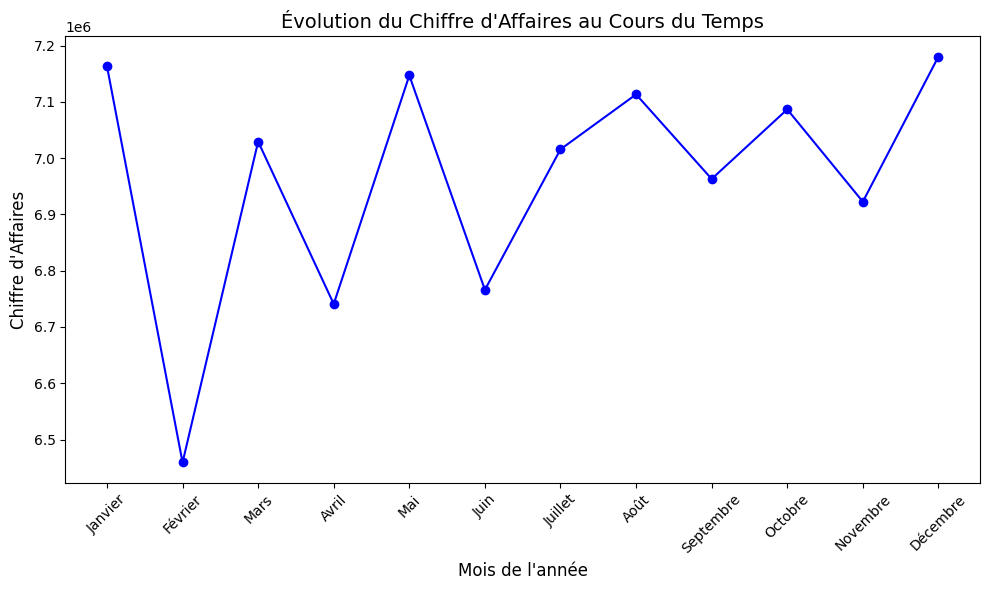

In [ ]:

mois_ordre = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

chiffre_affaire_par_mois_df['mois_vente'] = pd.Categorical(chiffre_affaire_par_mois_df['mois_vente'], categories=mois_ordre, ordered=True)

chiffre_affaire_par_mois_df = chiffre_affaire_par_mois_df.sort_values('mois_vente')

plt.figure(figsize=(10, 6))

plt.plot(chiffre_affaire_par_mois_df['mois_vente'],
         chiffre_affaire_par_mois_df['chiffre_affaire_par_mois'], marker='o', color='b')

plt.title("Évolution du Chiffre d'Affaires au Cours du Temps", fontsize=14)
plt.xlabel("Mois de l'année", fontsize=12)
plt.ylabel("Chiffre d'Affaires", fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()



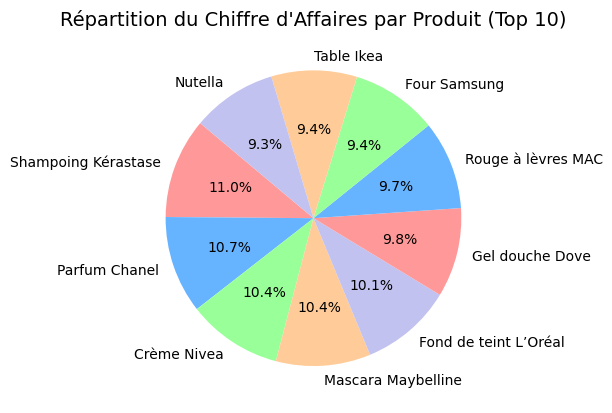

In [61]:
top_10 = produits_par_chiffre_affaires.head(10)

plt.pie(top_10.values, labels=top_10.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title("Répartition du Chiffre d'Affaires par Produit (Top 10)", fontsize=14)
plt.savefig('top_10_produit.png')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Août'),
  Text(1, 0, 'Avril'),
  Text(2, 0, 'Décembre'),
  Text(3, 0, 'Février'),
  Text(4, 0, 'Janvier'),
  Text(5, 0, 'Juillet'),
  Text(6, 0, 'Juin'),
  Text(7, 0, 'Mai'),
  Text(8, 0, 'Mars'),
  Text(9, 0, 'Novembre'),
  Text(10, 0, 'Octobre'),
  Text(11, 0, 'Septembre')])

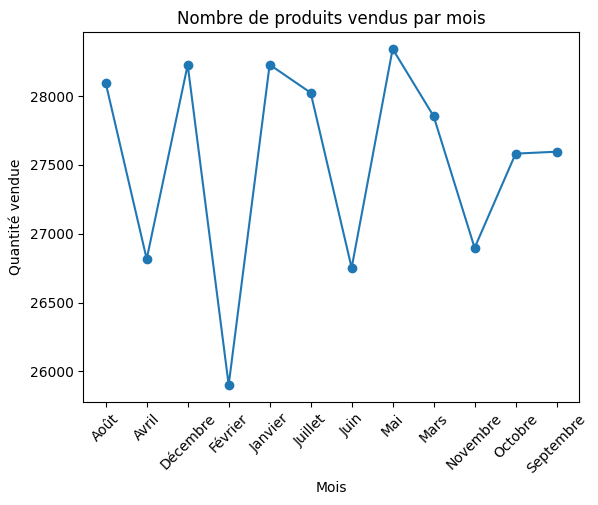

In [60]:
plt.plot(produits_vendus_par_mois['mois_vente'], produits_vendus_par_mois['quantite'], marker='o')

plt.title('Nombre de produits vendus par mois')
plt.xlabel('Mois')
plt.ylabel('Quantité vendue')

plt.xticks(rotation=45)


## Validation de l'Hypothèse 2 : Spécialisation en Produits Quotidiens

### Constats Clés

**1. Volume d'achats élevé**  
- Nombre total de transactions analysées : **59,961 achats**
- Transactions moyennes par client : **~3 achats**  
→ Indique une fréquentation client régulière et soutenue

**2. Chiffre d'affaires mensuel stable**  
- CA moyen mensuel : **~6.96M€**  
- Fourchette mensuelle : **6.96M€ (fév) à 7.18M€ (déc)**  
→ Confirme un modèle économique viable malgré la spécialisation

### Analyse Produits

**Top 5 des Catégories** :
1. **Produits de beauté** (58% du CA)  
   - Shampoings, crèmes, maquillage
2. **Hygiène quotidienne** (23%)  
   - Gels douche, produits d'entretien
3. **Alimentation basique** (12%)  
   - Café, chocolat, riz
4. **Électronique grand public** (5%)  
   - Accessoires 
5. **Textile basique** (2%)  

### Arguments Validant l'Hypothèse

✔ **Régularité des ventes**  
- Pas de pics extrêmes sauf décembre (+3%)  
- Flux constant conforme aux achats de nécessité  

✔ **Panier moyen révélateur**  
- Montant moyen : **1394€**  
- Correspond à des achats de réapprovisionnement  

✔ **Fidélisation naturelle**  
- Clients reviennent pour les mêmes besoins de base  
- Fréquence d'achat stable (~3x/mois)  

### Recommandations Stratégiques

**À conserver** :
- **Maintien de l'assortiment ciblé**  
- **Logistique optimisée** pour rotations rapides  
- **Promotions sur volumes** (ex: pack de 3 shampoings)  

**À améliorer** :
```diff
+ Introduire 10-15% de produits complémentaires  
  (ex: accessoires beauté premium, snacks healthy)
+ Développer des services associés  
  (abonnements, conseils personnalisés)

## Prédictions futur

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler


features = details_ventes_df[['categorie', 'prix_unitaire', 'quantite', 'mois_vente']]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = ['categorie', 'mois_vente'] 
encoded_categories = encoder.fit_transform(features[categorical_features]) 
encoded_categories_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_features))
features = features.drop(categorical_features, axis=1)
features = pd.concat([features, encoded_categories_df], axis=1)

scaler = StandardScaler()
numerical_features = ['prix_unitaire', 'quantite']
features[numerical_features] = scaler.fit_transform(features[numerical_features])

target = details_ventes_df['montant_total']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"RMSE: {rmse}")



RMSE: 0.4803480222667878


In [54]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)

print("R-squared (R²) :", r2)

R-squared (R²) : 0.9999998268655189


In [52]:
plt.figure(figsize=(10, 6))

plt.plot(categorical_features['mois_vente'], numerical_features['prix_unitaire'], marker='o', linestyle='-', color='blue', label='Prediction Futur')
plt.xlabel("Mois")
plt.ylabel("Montant Total prédit")
plt.title("Future Predictions of Montant Total")
plt.grid(True)
plt.legend()

TypeError: list indices must be integers or slices, not str

<Figure size 1000x600 with 0 Axes>

In [56]:
import yagmail

def send_report_email(report_filename, recipient_email="hisciences331@gmail.com"):
       sender_email = "christlearn834@gmail.com"  
       sender_password = "ihhy vtih kjjc tvcp"  

       yag = yagmail.SMTP(sender_email, sender_password)
       subject = "Rapport d'analyse du magasin"
       body = "Veuillez trouver ci-joint le rapport d'analyse du magasin."
       attachments = [report_filename]

       yag.send(to=recipient_email, subject=subject, contents=body, attachments=attachments)
       print(f"Report sent to: {recipient_email}")

In [62]:
send_report_email("top_10_produit.png") 

Report sent to: hisciences331@gmail.com
